In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from clifford import Cl
from mpl_toolkits.mplot3d import Axes3D

In [714]:
class Spinor:
    def __init__(self, clifford, vector, axial):
        self.clifford = clifford
        self.vector = vector
        self.axial = axial
        self.dim = self.clifford[0]+self.clifford[1]

        D, D_blades = Cl(self.clifford[0], self.clifford[1], firstIdx=0, names='g')
        globals().update(D_blades)
        I = ""
        for i in range(self.dim):
            I += f"{i}"
        g_ax = eval(f"g{I}")
        D_blades["g_ax"] = g_ax
        globals().update(D_blades)

        self.spinor = self.vector_to_spinor(self.vector) + self.axial_to_spinor(self.axial)

    def __mul__(self, other):
        product = self.spinor*other.spinor
        spinor = Spinor(self.clifford, self.spinor_to_vector(product))
        return spinor
    
    def tr(self, spinor):
        return spinor.value[0]
    
    def sgn(self, i):
        if i <= self.clifford[0] - 1:
            return 1
        else:
            return -1

    def vector_to_spinor(self, vector):
        spinor = np.sum([self.sgn(i)*vector[i]*eval(f"g{i}") for i in range(self.dim)])
        return spinor
    
    def axial_to_spinor(self, axial):
        spinor = np.sum([self.sgn(i)*axial[i]*g_ax*eval(f"g{i}") for i in range(self.dim)])
        return spinor

    def spinor_to_vector(self, spinor):
        vector = np.array([self.tr(spinor*eval(f"g{i}")) for i in range(self.dim)])
        return vector
    
    def to_vector(self):
        self.vector = self.spinor_to_vector(self.spinor)
        return self.vector
    
    def spinor_to_axial(self, spinor):
        axial = np.array([self.tr(spinor*g_ax*eval(f"g{i}")) for i in range(self.dim)])
        return axial
    
    def to_axial(self):
        self.axial = self.spinor_to_axial(self.spinor)
        return self.axial

    def spinor_project(self, spinor):
        return np.array([(1+g_ax)*spinor/2, (1-g_ax)*spinor/2])
    
    def project(self):
        self.projections = self.spinor_project(self.spinor)
        return self.projections
    
    def lorentz(self, rotation = [0,0,0], boost = [0,0,0]):
        # This function only makes sense in Cl(1,3)
        self.spinor = np.exp(-rotation[0]/2*g2*g3)*self.spinor*np.exp(rotation[0]/2*g2*g3)
        self.spinor = np.exp(-rotation[1]/2*g3*g1)*self.spinor*np.exp(rotation[1]/2*g3*g1)
        self.spinor = np.exp(-rotation[2]/2*g1*g2)*self.spinor*np.exp(rotation[2]/2*g1*g2)

        self.spinor = np.exp(-boost[0]/2*g0*g1)*self.spinor*np.exp(boost[0]/2*g0*g1)
        self.spinor = np.exp(-boost[1]/2*g0*g2)*self.spinor*np.exp(boost[1]/2*g0*g2)
        self.spinor = np.exp(-boost[2]/2*g0*g3)*self.spinor*np.exp(boost[2]/2*g0*g3)

        self.to_vector()
        self.to_axial()

    def helicity(self):
        # This function only makes sense in Cl(1,3)
        self.helicity = np.sum(self.vector[1:]*self.axial[1:])/(np.linalg.norm(self.vector[1:])*np.linalg.norm(self.axial[1:]))
        return self.helicity

    def plot(self, which = [1,2,3]):
        soa = np.array([[0, 0, 0, self.vector[which[0]], self.vector[which[1]], self.vector[which[2]]],\
                        [0, 0, 0, self.axial[which[0]], self.axial[which[1]], self.axial[which[2]]]])

        X, Y, Z, U, V, W = zip(*soa)
        colors = ['r', 'b']
        fig = plt.figure(figsize = (9,6))
        ax = fig.add_subplot(111, projection='3d')
        for i in range(len(X)):
            ax.quiver(X[i], Y[i], Z[i], U[i], V[i], W[i], color=colors[i])

        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = np.cos(u)*np.sin(v)
        y = np.sin(u)*np.sin(v)
        z = np.cos(v)
        ax.plot_wireframe(x, y, z, color="k", alpha=0.5)

        ax.legend(["P", "S"])
        ax.set_xlabel(r"$X_1$")
        ax.set_ylabel(r"$X_2$")
        ax.set_zlabel(r"$X_3$")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        plt.show()
        

# Explanation
What we are effectively doing is considering not $\psi$ as states but
$$\rho = \psi \psi^\dagger$$
as states, like in quantum information theory. The density matrix $\rho$ is Hermitian, which makes that each vector can be written in terms of the gamma matrices, $\gamma^\mu$ and their adjoints $\gamma^5 \gamma^\mu$:
$$\rho = \alpha_\mu  \gamma^\mu + \beta_\mu  \gamma^5 \gamma^\mu$$
where $\alpha$ corresponds to a vector quantity and $\beta$ to a axial/pseudo-vector quantity. To retrieve either of them, you just do the following
$$\alpha^\mu = \text{tr}( \gamma^\mu \rho) = \psi^\dagger \gamma^\mu \psi$$
and
$$\beta^\mu = \text{tr}( \gamma^5 \gamma^\mu \rho) = \psi^\dagger \gamma^5 \gamma^\mu \psi$$

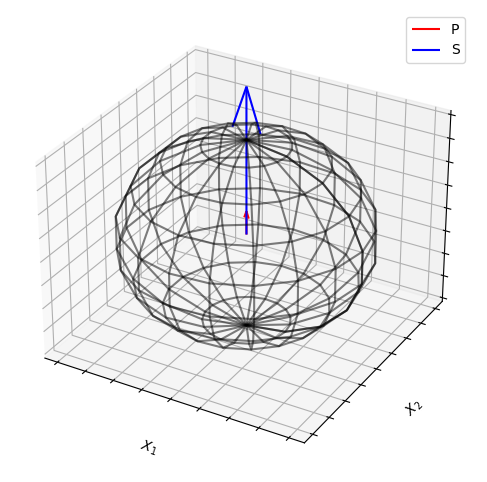

h = 1.0


In [729]:
P=[1,0,0,1]
S=[0,0,0,1]

s = Spinor([1,3], P, S)
s.lorentz([0,0,0], [0,0,1])
s.plot()

print(f"h = {s.helicity()}")

In [727]:
s.vector

array([0.00247875, 0.        , 0.        , 0.00247875])